## Example 11 - Multiple vessels - from database

In [1]:
import opentnsim
print('This notebook has been tested with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook has been tested with OpenTNSim version 1.0.0


In [2]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# OpenTNSIM
import opentnsim.core as core
import opentnsim.graph_module as graph_module
import opentnsim.plot as plot
import opentnsim.model as model

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

# Graph location
location_graph = "Shape-Files/Rotterdam-Antwerpen-corridor"
name_graph = "edges_2.shp"

# Vessel database
location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda)):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

In [3]:
graph = graph_module.Graph()
graph.from_shape(location_graph, name_graph)

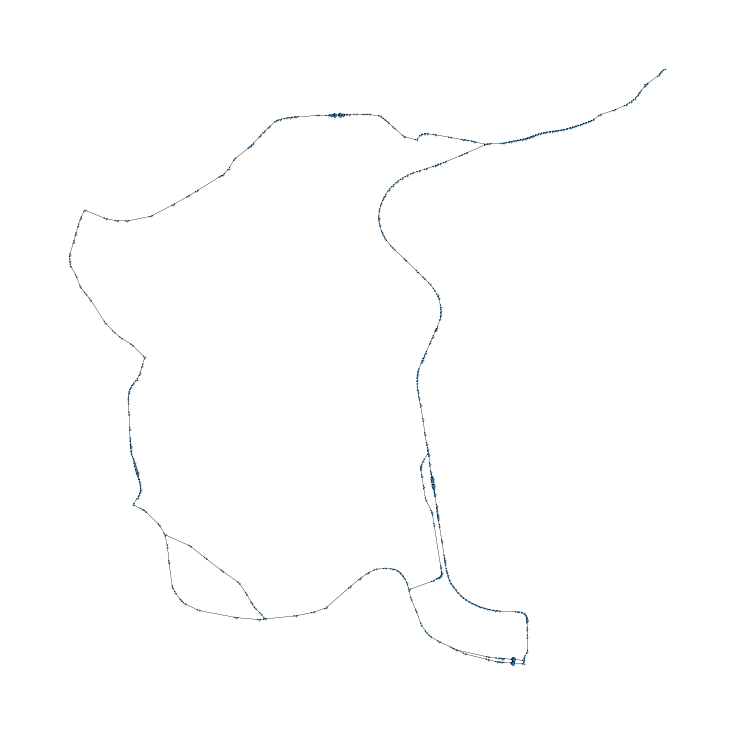

In [4]:
graph.create_graph_new_projection()
graph.plot()

### Create vessel database

In [5]:
vessel_db = pd.read_csv(location_vessel_database)
vessel_db.head()

,vessel_id,vessel_type,width,length,height_empty,height_full,draught_empty,draught_full,capacity,installed_power
0,12ad8a02-4aef-11e9-9940-b469212bff5b,CEMT - I,5.05,38.5,4.65,3.35,1.2,2.5,365,175
1,17746aee-4aef-11e9-8ebf-b469212bff5b,CEMT - II,6.60,55.0,5.80,4.60,1.4,2.6,615,250
2,1be5fb2e-4aef-11e9-9bfb-b469212bff5b,CEMT - III,8.20,85.0,6.30,5.10,1.5,2.7,1250,435
3,208a5aca-4aef-11e9-b7e9-b469212bff5b,CEMT - IV,9.50,105.0,6.70,5.30,1.6,3.0,2040,690
4,24f93100-4aef-11e9-8ff9-b469212bff5b,CEMT - Va,11.40,135.0,7.10,5.40,1.8,3.5,3735,1425


In [6]:
# Vessel type
Vessel = type('Vessel', 
              (core.Identifiable, core.Movable, core.HasContainer,
               core.VesselProperties, core.HasResource, core.Routeable), 
              {})

In [7]:
generator = model.VesselGenerator(Vessel, vessel_db)

### Run simulation

In [8]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))

# Add graph to environment
graph.add_resources(list(graph.graph.edges), np.ones(len(list(graph.graph.edges))), env)
env.FG = graph.graph

In [9]:
def start(env, vessel):
    while True:
        
        vessel.log_entry("Start sailing", env.now, "0", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "0", vessel.geometry)

        if vessel.geometry == nx.get_node_attributes(env.FG, "geometry")[vessel.route[-1]]:
            break

In [10]:
vessels = []

# Add 10 vessels to the simulation
for i in range(10):
    random_1 = random.choice(list(graph.graph))
    random_2 = random.choice(list(graph.graph))
    path = nx.dijkstra_path(graph.graph, random_1, random_2)
    
    vessel = generator.generate(env, "Vessel " + str(i))
    vessel.route = path
    vessel.geometry = nx.get_node_attributes(env.FG, "geometry")[vessel.route[0]]
    vessels.append(vessel)
    
    # Add the movements of the vessel to the simulation
    env.process(start(env, vessel))

In [11]:
# Run simulation
env.run()

### Check results

In [12]:
df = pd.DataFrame.from_dict(vessel.log)
df.head()

,Message,Timestamp,Value,Geometry
0,Start sailing,2020-05-08 14:55:50.000000,0,POINT (4.2198 51.5136)
1,"Waiting to pass edge (4.219800, 51.513600) - (...",2020-05-08 14:55:50.000000,0,POINT (4.2198 51.5136)
2,"Waiting to pass edge (4.219800, 51.513600) - (...",2020-05-08 15:05:09.421943,0,POINT (4.2198 51.5136)
3,"Sailing from node (4.219800, 51.513600) to nod...",2020-05-08 15:05:09.421943,0,POINT (4.2198 51.5136)
4,"Sailing from node (4.219800, 51.513600) to nod...",2020-05-08 15:14:28.843886,0,POINT (4.2222 51.5184)


In [13]:
vessel.log

{'Message': ['Start sailing',
  'Waiting to pass edge (4.219800, 51.513600) - (4.222200, 51.518400) start',
  'Waiting to pass edge (4.219800, 51.513600) - (4.222200, 51.518400) stop',
  'Sailing from node (4.219800, 51.513600) to node (4.222200, 51.518400) start',
  'Sailing from node (4.219800, 51.513600) to node (4.222200, 51.518400) stop',
  'Sailing from node (4.222200, 51.518400) to node (4.222915, 51.519631) start',
  'Sailing from node (4.222200, 51.518400) to node (4.222915, 51.519631) stop',
  'Sailing from node (4.222915, 51.519631) to node (4.223780, 51.521194) start',
  'Sailing from node (4.222915, 51.519631) to node (4.223780, 51.521194) stop',
  'Sailing from node (4.223780, 51.521194) to node (4.225200, 51.523700) start',
  'Sailing from node (4.223780, 51.521194) to node (4.225200, 51.523700) stop',
  'Waiting to pass edge (4.225200, 51.523700) - (4.228499, 51.529474) start',
  'Waiting to pass edge (4.225200, 51.523700) - (4.228499, 51.529474) stop',
  'Sailing from 